In [1]:
import scqubits as scq
import qutip as qt
import numpy as np
import scipy as sp
import cupy as cp
import cupyx as cpx
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os
# Add the src directory to the sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from chain_mode import ChainMode
from _usefull_functions import *
scq.settings.NUM_CPUS = 12

%matplotlib widget

# Benchmark the chain modes calculation from Viola paper

In [2]:
dict_benchmark1 = {'number_of_chain_junctions' : 43, 
                     'josephson_energy_of_chain_junctions' : 26, 
                     'capacitance_to_ground_of_chain_junctions' : 0.099, 
                     'area_of_chain_junctions' :  0.347, 
                     'charging_energy_of_fluxonium' : 3.6}
dict_benchmark2 = {'number_of_chain_junctions' : 95, 
                     'josephson_energy_of_chain_junctions' : 48.3, 
                     'capacitance_to_ground_of_chain_junctions' : 0.04, 
                     'area_of_chain_junctions' :  0.426, 
                     'charging_energy_of_fluxonium' : 4.78}

cm_benchmark1 = ChainMode(chain_mode_frequency = 3, truncated_dim = 3, chain_mode_index=1, **dict_benchmark1)
cm_benchmark2 = ChainMode(chain_mode_frequency = 3, truncated_dim = 3, chain_mode_index=1, **dict_benchmark2)

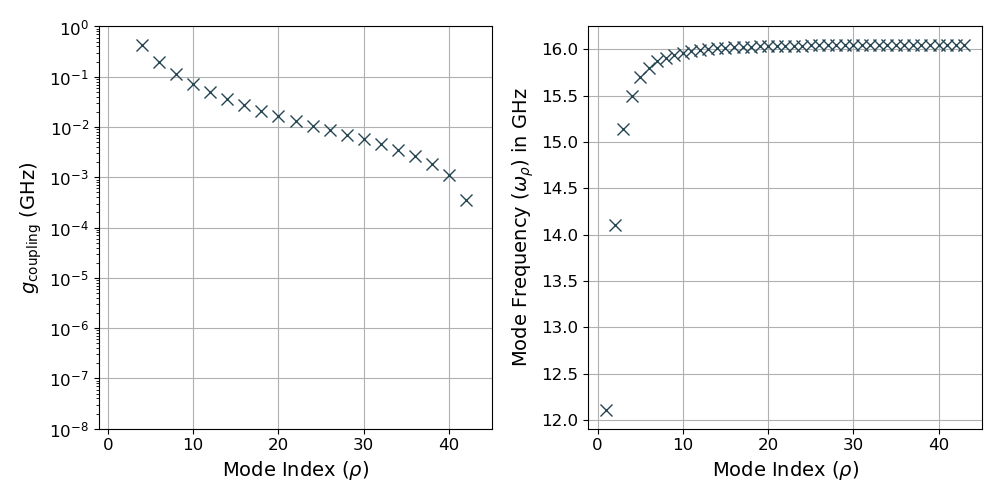

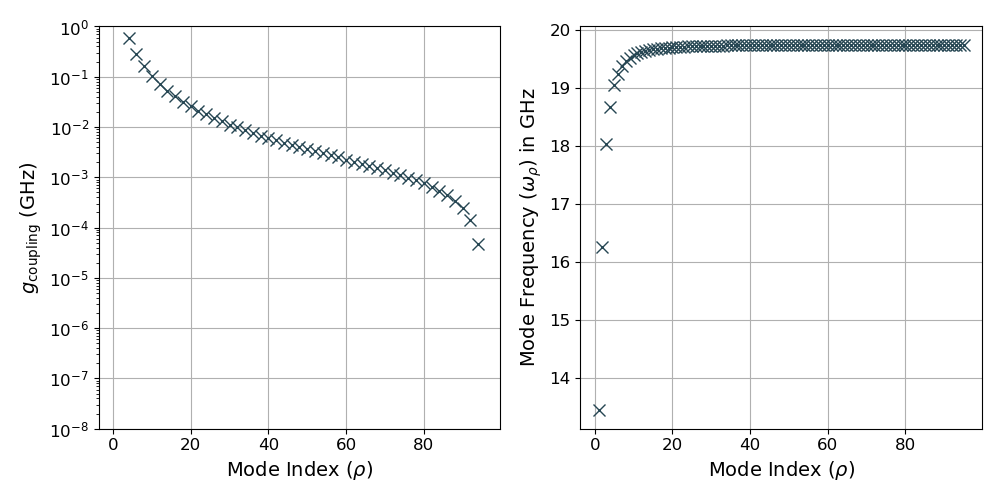

In [3]:
fig1 = cm_benchmark1.plot_dispersion_and_coupling()[0]
fig2 = cm_benchmark2.plot_dispersion_and_coupling()[0]

# Create fluxonium object

In [4]:
# Define Fluxonium parameters
ej = 6   # Josephson energy
ec = 1.2   # Charging energy
el = 0.06   # Inductive energy
phi_ext = 0.0  # External magnetic flux in flux quanta
Ncutoff = 100  # Cutoff for charge basis

fluxonium = scq.Fluxonium(EJ = ej, EC = ec, EL = el, flux = phi_ext, cutoff = Ncutoff, truncated_dim = 100)

phi_ext_values = np.linspace(-0.6, 0.6, 100)
max_level = 10 # number of the subspace we want to calculate transitions between

et = compute_spectrum(fluxonium, fluxonium, phi_ext_values, max_level)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.86it/s]


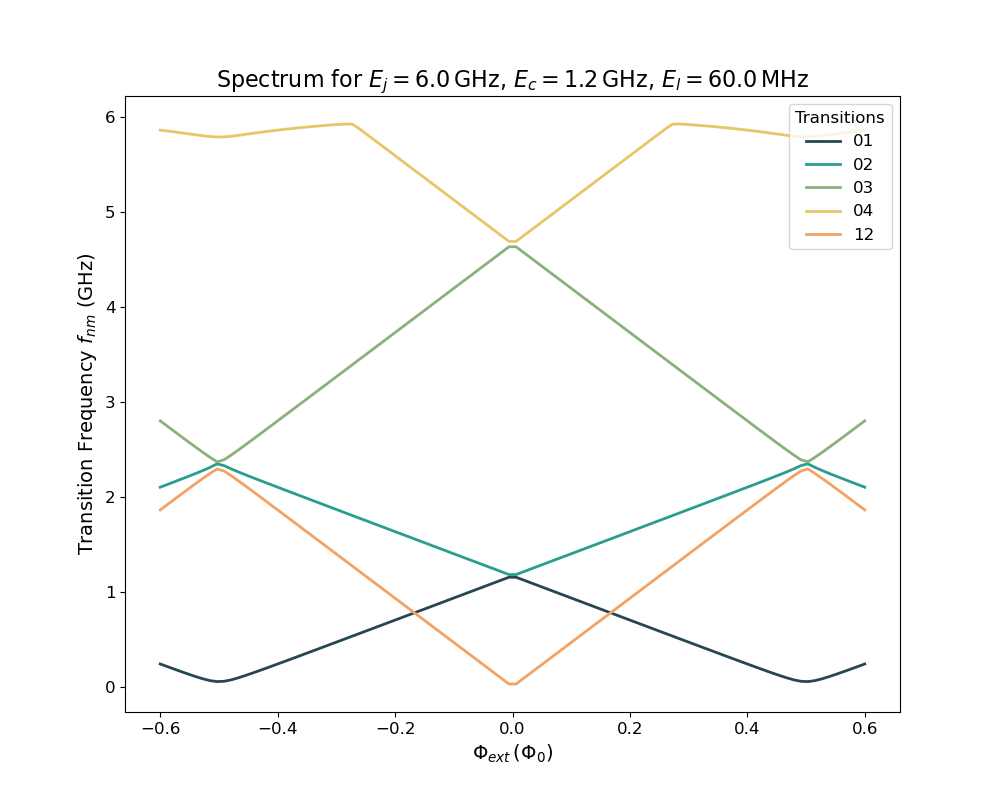

In [5]:
list_transistion_spectrum = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2),]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Plot each transition
for lower, upper in list_transistion_spectrum:
    transition_label = f"{lower}{upper}"  # Label e.g., '01', '02', etc.
    transition_data = np.array(et[(lower, upper)])  # Extract data for each transition
    ax.plot(phi_ext_values, transition_data, label=transition_label)

# Customizing the plot
ax.set_xlabel(r'$\Phi_{ext} \, (\Phi_0)$')
ax.set_ylabel(r'Transition Frequency $f_{nm}$ (GHz)')
ax.set_title(f'Spectrum for $E_j = {ej:.1f}\,$GHz, $E_c = {ec:.1f}\,$GHz, $E_l = {el*1e3:.1f}\,$MHz')
ax.legend(title='Transitions', loc='upper right')

plt.show()

# Create our chain modes

In [6]:
Chain_dictionnary = {'number_of_chain_junctions' : 1498, 
                     'josephson_energy_of_chain_junctions' : 0.066*1498, 
                     'capacitance_to_ground_of_chain_junctions' : 0.012, 
                     'area_of_chain_junctions' :  0.21 * 1.837, 
                     'charging_energy_of_fluxonium' : 1.0}

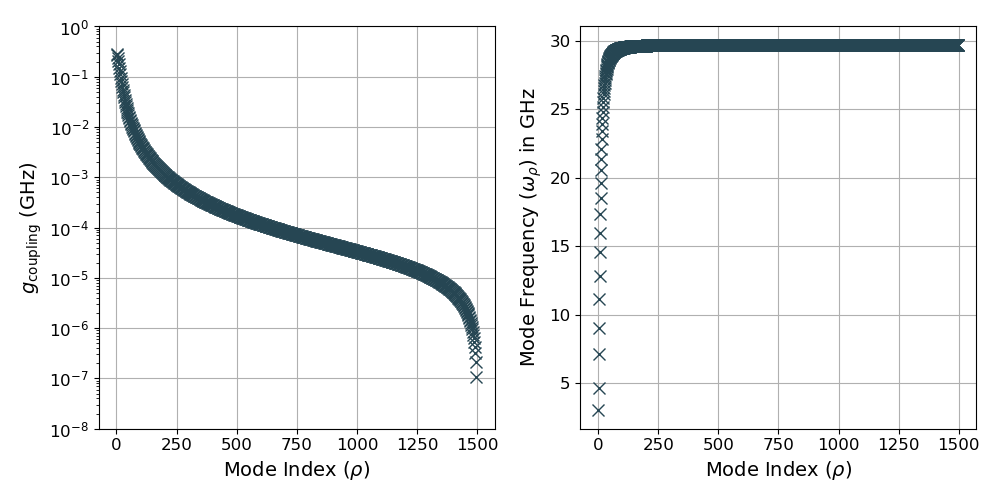

In [7]:
cm1 = ChainMode(chain_mode_frequency = 3, truncated_dim = 3, chain_mode_index=1, **Chain_dictionnary)
cm2 = ChainMode(chain_mode_frequency = 3, truncated_dim = 3, chain_mode_index=2, **Chain_dictionnary)

cm1.set_frequency_to_theory()
cm2.set_frequency_to_theory()

fig_dispersion = cm1.plot_dispersion_and_coupling()[0]
fig_dispersion.axes[1].set_xscale('log')
fig_dispersion.axes[1].set_yscale('log')

# Coupling the chain mode to the fluxonium 

In [8]:
# Create a Hilbert space
hilbert_space = scq.HilbertSpace([fluxonium, cm1, cm2])

# Define interaction (this is an example, adjust as needed)
# Assuming a capacitive coupling as a simple example
g_coupling1 = cm1.coupling_to_fluxonium()
print(f'the coupling strength of first mode in GHz: {g_coupling1:.3f}')

g_coupling2 = cm2.coupling_to_fluxonium()
print(f'the coupling strength of second mode in GHz: {g_coupling2:.3f}')

hilbert_space.add_interaction(g = g_coupling1, op1 = fluxonium.n_operator, op2 =  cm1.n_operator, add_hc= False)
hilbert_space.add_interaction(g = g_coupling2, op1 = fluxonium.n_operator, op2 =  cm2.n_operator, add_hc= False)

et_coupled_fluxonium_chain_mode = compute_spectrum(hilbert_space, fluxonium, phi_ext_values)

the coupling strength of first mode in GHz: 0.000
the coupling strength of second mode in GHz: 0.285


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


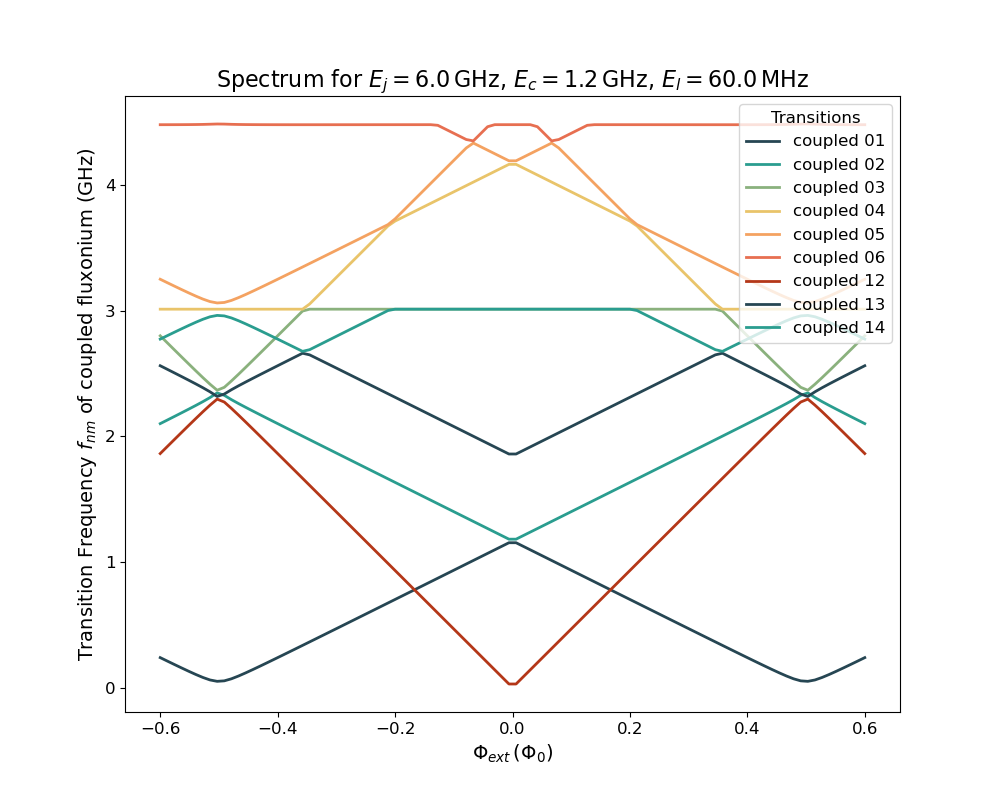

In [9]:
list_transistion_spectrum = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5),(0, 6), (1, 2), (1, 3), (1, 4)]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Plot each transition
for lower, upper in list_transistion_spectrum:
    transition_label = 'coupled ' +f"{lower}{upper}"  # Label e.g., '01', '02', etc.
    transition_data = np.array(et_coupled_fluxonium_chain_mode[(lower, upper)])  # Extract data for each transition
    ax.plot(phi_ext_values, transition_data, label=transition_label )


# Customizing the plot
ax.set_xlabel(r'$\Phi_{ext} \, (\Phi_0)$')
ax.set_ylabel(r'Transition Frequency $f_{nm}$ of coupled fluxonium (GHz)')
ax.set_title(f'Spectrum for $E_j = {ej:.1f}\,$GHz, $E_c = {ec:.1f}\,$GHz, $E_l = {el*1e3:.1f}\,$MHz')
ax.legend(title='Transitions', loc='upper right')

plt.show()

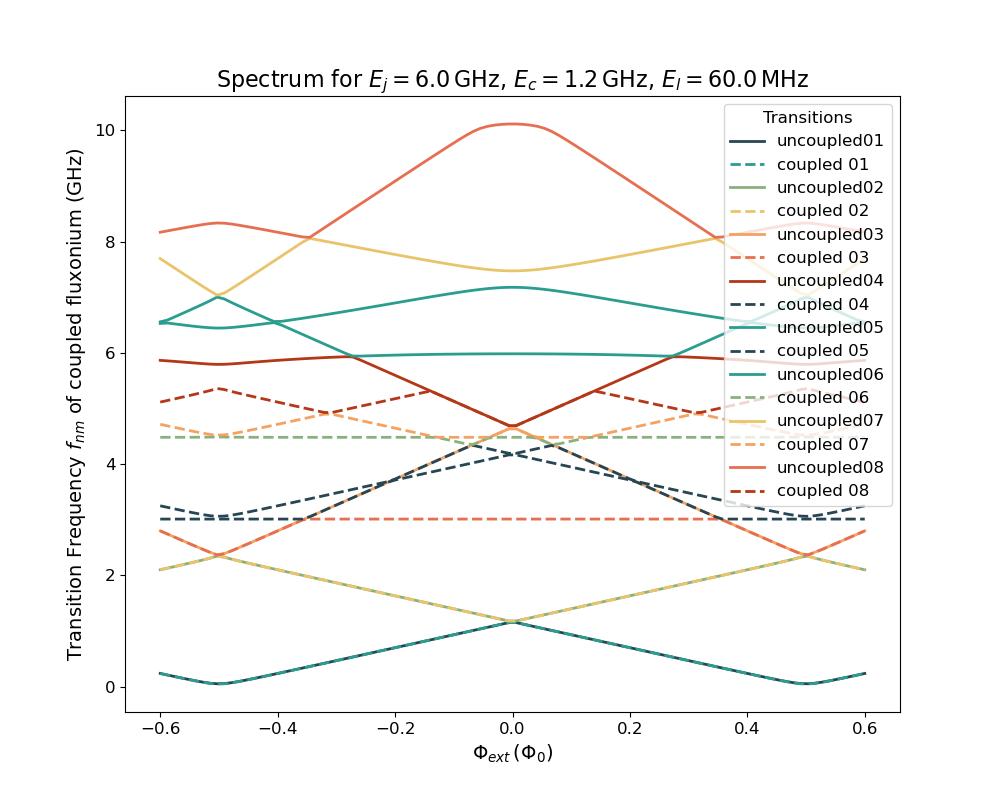

In [10]:
list_transistion_spectrum = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Plot each transition
k =0
for lower, upper in list_transistion_spectrum:
    transition_label = 'uncoupled' + f"{lower}{upper}"  # Label e.g., '01', '02', etc.
    transition_data = np.array(et[(lower, upper)])  # Extract data for each transition
    ax.plot(phi_ext_values, transition_data, label=transition_label)
    transition_label = 'coupled ' + f"{lower}{upper}"  # Label e.g., '01', '02', etc.
    transition_data = np.array(et_coupled_fluxonium_chain_mode[(lower, upper)])  # Extract data for each transition
    ax.plot(phi_ext_values, transition_data, label=transition_label,  linestyle = 'dashed')
    k+=1

# Customizing the plot
ax.set_xlabel(r'$\Phi_{ext} \, (\Phi_0)$')
ax.set_ylabel(r'Transition Frequency $f_{nm}$ of coupled fluxonium (GHz)')
ax.set_title(f'Spectrum for $E_j = {ej:.1f}\,$GHz, $E_c = {ec:.1f}\,$GHz, $E_l = {el*1e3:.1f}\,$MHz')
ax.legend(title='Transitions', loc='upper right')

plt.show()

# calculation of dispersive shift

In [11]:
compute_chi_terms(fluxonium, cm2, 30)*1e3

-16.399185920892563

In [19]:
phi_ext_values= np.arange(-0.6,0.6,0.01)
rho = 2
cm2.chain_mode_index = rho  # Assuming cm2 is a predefined ChainMode object

# Initialize an array to store chi values for the chain mode index rho
chi_values_for_mode_rho = np.zeros_like(phi_ext_values, dtype=float)

# Loop over all external flux values and compute chi for the mode index rho
for i, phi_ext in tqdm(enumerate(phi_ext_values)):
    # Set the external flux for the fluxonium system
    fluxonium.flux = phi_ext
    # Compute chi terms using the compute_chi_terms function and convert to MHz
    chi_values_for_mode_rho[i] = compute_chi_terms(fluxonium, cm2, 99)*1e3

120it [00:02, 43.70it/s]


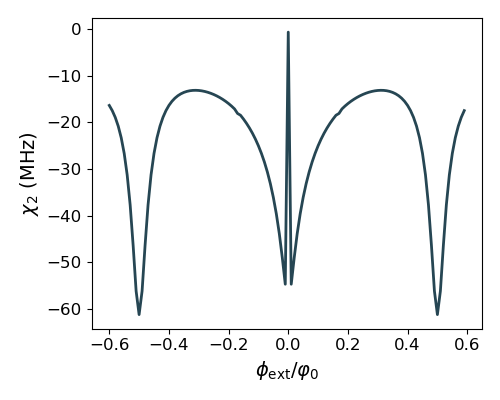

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(phi_ext_values, chi_values_for_mode_rho)
# Set the y-axis label with the mode index rho
ax.set_ylabel(f'$\chi_{ {rho}} $ (MHz)')
# Set the x-axis label as the normalized external flux
ax.set_xlabel(r'$\phi_\text{ext}/\varphi_0$')
fig.tight_layout()
plt.show()  # Display the plot

In [21]:
rhos = np.arange(2,cm2.number_of_chain_junctions,2)

phi = 0
fluxonium.flux = phi

# Initialize an array to store chi values 
chi_rhos_phi = np.zeros_like(rhos, dtype=float)
# Loop over all mode indices and compute chi for the flux phi
for i, mode_index in tqdm(enumerate(rhos)):    
    # Set the mode index of the chain mode
    cm2.chain_mode_index= mode_index
    # Compute chi terms using the compute_chi_terms function and convert to MHz
    chi_rhos_phi[i] = compute_chi_terms(fluxonium, cm2, 99)*1e3

748it [00:14, 53.30it/s]


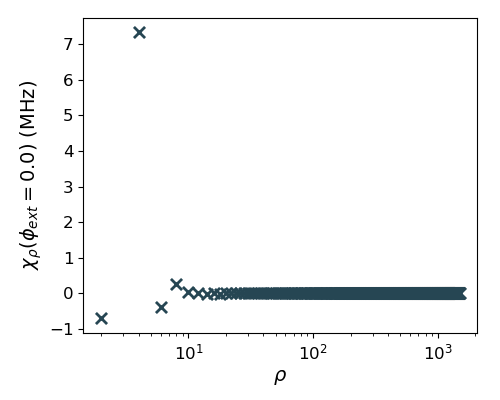

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(rhos, chi_rhos_phi, marker = 'x')
# Set the y-axis label 
ax.set_ylabel(r'$\chi_{\rho}$' + f'$(\phi_{{{{ext}}}} = {fluxonium.flux:.1f})$ (MHz)')
# Set the x-axis label as the normalized external flux
ax.set_xlabel(r'$\rho$')
fig.tight_layout()
ax.set_xscale('log')
plt.show()  # Display the plot

# Calculate the shot noise time 

# Cheking calculation time

In [16]:
max_level = 10
%timeit  get_transitions(hilbert_space, max_level+1)

157 ms ± 6.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%whos

Variable                          Type             Data/Info
------------------------------------------------------------
ChainMode                         _ProtocolMeta    <class 'chain_mode.ChainMode'>
Chain_dictionnary                 dict             n=5
Ncutoff                           int              100
ax                                Axes             Axes(0.166806,0.168194;0.788035x0.786806)
chi_rhos_0                        ndarray          748: 748 elems, type `float64`, 5984 bytes
chi_values_for_mode_rho           ndarray          120: 120 elems, type `float64`, 960 bytes
cm1                               ChainMode        ChainMode-----------| [Ch<...>               | dim: 3\n
cm2                               ChainMode        ChainMode-----------| [Ch<...>               | dim: 3\n
cm_benchmark1                     ChainMode        ChainMode-----------| [Ch<...>               | dim: 3\n
cm_benchmark2                     ChainMode        ChainMode-----------| [Ch<...>    